In [1]:
import sys
# point path to genesis repo
sys.path.insert(
    0,
    '/gpfs/commons/home/tchen/al_project/genesis/analysis/splicing'
)

In [2]:
import os
from definitions.generator.splirent_deconv_conv_generator_concat import load_generator_network
from genesis.generator import build_generator, st_sampled_softmax, st_hardmax_softmax
from pathlib import Path
from keras.models import load_model, Model
from keras import backend as K
import numpy as np
from genesis.visualization import plot_seqprop_logo
from definitions.predictor.splirent_only_random_regions import load_saved_predictor
from keras.layers import Lambda, Reshape
from keras import Input
import tensorflow as tf
from genesis.predictor.genesis_predictor import build_predictor

Using TensorFlow backend.


## Testing generated sequences from our PyTorch model with keras code from genesis

Now let's load in the saved predictor model from genesis

In [8]:
model_name = 'genesis_splicing_cnn_target_isoform_00_pwm_and_multisample_hek_only_random_regions_50_epochs_harderentropy_predictor.h5'
# model_name = 'genesis_splicing_cnn_target_isoform_10_pwm_and_multisample_hek_only_random_regions_70_epochs_harderentropy_predictor.h5'
model_save_dir = '/gpfs/commons/groups/knowles_lab/ting/DEN_splicing_pretrained_models/'

full_path = model_save_dir + model_name

# predictor_model = load_model(filepath=str(full_path), custom_objects={'K': K, 'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax}, compile=False)

In [16]:
predictor_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_sampled_pwm (InputLayer)  (320, 109, 4, 1)     0                                            
__________________________________________________________________________________________________
lambda_9 (Lambda)               (320, 35, 4)         0           input_sampled_pwm[0][0]          
__________________________________________________________________________________________________
lambda_10 (Lambda)              (320, 35, 4)         0           input_sampled_pwm[0][0]          
__________________________________________________________________________________________________
splirent_conv_1 (Conv1D)        (320, 35, 96)        3168        lambda_9[0][0]                   
                                                                 lambda_10[0][0]                  
__________

In [4]:
model_name = 'genesis_splicing_cnn_target_isoform_00_pwm_and_multisample_hek_only_random_regions_50_epochs_harderentropy_generator.h5'
model_save_dir = '/gpfs/commons/groups/knowles_lab/ting/DEN_splicing_pretrained_models/'

full_path = model_save_dir + model_name
generator_model = load_model(filepath=str(full_path), custom_objects={'K': K, 'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax}, compile=False)

2024-03-10 19:37:32.602950: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2024-03-10 19:37:32.610651: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2400000000 Hz
2024-03-10 19:37:32.612546: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55fceaedde90 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-03-10 19:37:32.612573: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


Instructions for updating:
Use `tf.random.categorical` instead.



In [12]:
generator_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence_class_seed (InputLayer (32, 1)              0                                            
__________________________________________________________________________________________________
lambda_rand_sequence_class (Lam (32, 1)              0           sequence_class_seed[0][0]        
__________________________________________________________________________________________________
noise_input_1 (InputLayer)      (32, 100)            0                                            
__________________________________________________________________________________________________
noise_input_2 (InputLayer)      (32, 100)            0                                            
__________________________________________________________________________________________________
lambda_ran

In [5]:
# generate some samples from generator
n = 32

sequence_class = np.array([0] * n).reshape(-1, 1) #np.random.uniform(-6, 6, (n, 1)) #

noise_1 = np.random.uniform(-1, 1, (n, 100))
noise_2 = np.random.uniform(-1, 1, (n, 100))

gen_outputs = generator_model.predict([sequence_class, noise_1, noise_2], batch_size=32)

gen_pwm = gen_outputs[3]
gen_samples = gen_outputs[5]

In [16]:
generator_model.outputs

[<tf.Tensor 'lambda_rand_sequence_class_1/Identity:0' shape=(32, 1) dtype=int32>,
 <tf.Tensor 'masking_layer_2/add:0' shape=(32, 109, 4, 1) dtype=float32>,
 <tf.Tensor 'masking_layer_3/add:0' shape=(32, 109, 4, 1) dtype=float32>,
 <tf.Tensor 'pwm_1_1/truediv:0' shape=(32, 109, 4, 1) dtype=float32>,
 <tf.Tensor 'pwm_2_1/truediv:0' shape=(32, 109, 4, 1) dtype=float32>,
 <tf.Tensor 'lambda_10_1/transpose:0' shape=(32, 10, 109, 4, 1) dtype=float32>,
 <tf.Tensor 'lambda_11_1/transpose:0' shape=(32, 10, 109, 4, 1) dtype=float32>,
 <tf.Tensor 'reshape_4_3/Reshape:0' shape=(32, 109, 4, 1) dtype=float32>,
 <tf.Tensor 'lambda_12_1/transpose:0' shape=(32, 10, 109, 4, 1) dtype=float32>]

In [4]:
# _, sample_predictor = build_predictor(generator_model, load_saved_predictor(full_path, library_contexts=None, custom_objects={'K': K, 'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax}), 32, n_samples=10, eval_mode='sample')

NameError: name 'generator_model' is not defined

Rip out sample predictor to predict on PyTorch generated sequences

In [9]:
batch_size = 32
n_samples = 10
use_samples = True
eval_mode = 'sample'
# if n_samples is None :
#     use_samples = False
#     n_samples = 1

# sequence_class not used for loading in predictor model
# sequence_class = generator_model.outputs[0]
pwm = None
sampled_pwm = Input(shape=(109, 4, 1), batch_shape=(320, 109, 4, 1), name='input_sampled_pwm')
# sampled_pwm = generator_model.outputs[5]

seq_input = None
class_input = None
# class_input = sequence_class
if eval_mode == 'pwm' :
    seq_input = pwm
elif eval_mode == 'sample' :
    seq_input = sampled_pwm
    if use_samples :
        # seq_input = Lambda(lambda x: K.reshape(x, (K.shape(x)[0] * K.shape(x)[1], K.shape(x)[2], K.shape(x)[3], K.shape(x)[4])))(seq_input)
        # seq_input = Reshape((K.shape(sampled_pwm)[0] * K.shape(sampled_pwm)[1], K.shape(sampled_pwm)[2], K.shape(sampled_pwm)[3], K.shape(sampled_pwm)[4]))(seq_input)
        # class_input = Lambda(lambda x: K.tile(x[0], (K.shape(x[1])[1], 1)))([class_input, sampled_pwm])
        pass

predictor_inputs, predictor_outputs, post_compile_function = load_saved_predictor(full_path,  custom_objects={'K': K, 'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax})(seq_input, class_input)

In [7]:
predictor_inputs

[<tf.Tensor 'lambda_1_1/Reshape:0' shape=(320, 109, 4, 1) dtype=float32>]

In [10]:
#Optionally create sample axis
if use_samples :
    predictor_outputs = [
        Lambda(lambda x: K.reshape(x, (batch_size, n_samples, K.shape(x)[-1])))(predictor_output)
        #Lambda(lambda x: K.reshape(x, (n_samples, batch_size, K.shape(x)[-1])))(predictor_output)
        for predictor_output in predictor_outputs
    ]

predictor_model = Model(
    inputs = predictor_inputs,
    outputs = predictor_outputs
)

post_compile_function(predictor_model)

In [6]:
# load generated samples
save_path = '/gpfs/commons/groups/knowles_lab/ting/'
# save_name = 'pytorch_generated_sequences_target_isoform_00.npy'
save_name = 'pytorch_generated_sequences_target_isoform_10.npy'

generated_sequences = np.load(save_path+save_name, allow_pickle=True)

In [7]:
# load optimized pwm
save_path = '/gpfs/commons/groups/knowles_lab/ting/'
# save_name = 'pytorch_optimized_pwm_target_isoform_00.npy'
save_name = 'pytorch_optimized_pwm_target_isoform_10.npy'

optimized_pwm = np.load(save_path+save_name, allow_pickle=True)

In [10]:
predictor_outputs

[<tf.Tensor 'splirent_hek_dense_2/Sigmoid:0' shape=(320, 1) dtype=float32>,
 <tf.Tensor 'splirent_hela_dense_2/Sigmoid:0' shape=(320, 1) dtype=float32>,
 <tf.Tensor 'splirent_mcf7_dense_2/Sigmoid:0' shape=(320, 1) dtype=float32>,
 <tf.Tensor 'splirent_cho_dense_2/Sigmoid:0' shape=(320, 1) dtype=float32>]

In [23]:
np.around(optimized_pwm.reshape((32, 109, 4))[0], decimals=3)

array([[1.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 1.   , 0.   ],
       [0.   , 0.   , 1.   , 0.   ],
       [0.   , 0.   , 0.   , 1.   ],
       [0.   , 0.   , 1.   , 0.   ],
       [0.   , 1.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 1.   ],
       [0.   , 0.   , 0.   , 1.   ],
       [0.   , 0.   , 1.   , 0.   ],
       [0.   , 0.   , 1.   , 0.   ],
       [0.   , 0.   , 0.   , 1.   ],
       [0.   , 0.   , 1.   , 0.   ],
       [0.   , 0.   , 0.   , 1.   ],
       [0.   , 0.   , 0.   , 1.   ],
       [0.   , 0.   , 0.   , 1.   ],
       [0.   , 0.   , 1.   , 0.   ],
       [0.   , 0.   , 0.   , 1.   ],
       [0.   , 0.   , 1.   , 0.   ],
       [0.   , 0.   , 0.   , 1.   ],
       [0.   , 0.   , 1.   , 0.   ],
       [1.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 1.   ],
       [0.065, 0.   , 0.   , 0.935],
       [0.001, 0.   , 0.   , 0.999],
       [1.   , 0.   , 0.   , 0.   ],
       [0.003, 0.   , 0.   , 0.997],
       [0.   , 0.   , 1.   , 0.   ],
 

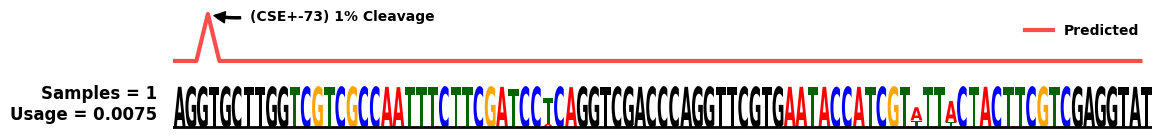

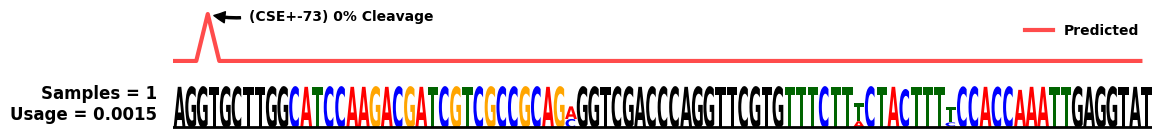

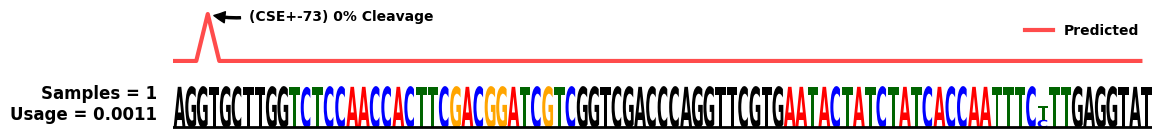

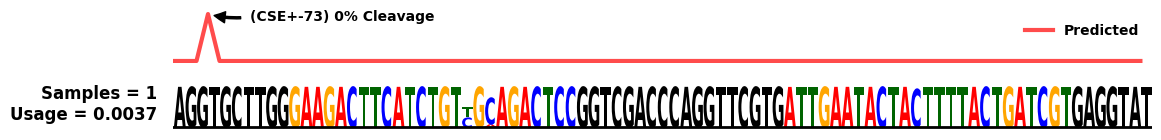

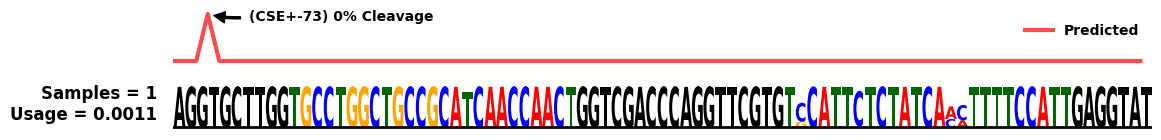

In [11]:

sequence_template = 'AGGTGCTTGGNNNNNNNNNNNNNNNNNNNNNNNNNGGTCGACCCAGGTTCGTGNNNNNNNNNNNNNNNNNNNNNNNNNGAGGTATTCTTATCACCTTCGTGGCTACAGA'

n = 32
sequence_class = np.array([0] * n).reshape(-1, 1) #np.random.uniform(-6, 6, (n, 1)) #

# tf_generated_sequences = tf.convert_to_tensor(generated_sequences.reshape(320, 109, 4, 1))
tf_generated_sequences = tf.convert_to_tensor(gen_samples.reshape(320, 109, 4, 1))
optimized_pwm = gen_pwm
pred_outputs = predictor_model.predict(tf_generated_sequences, steps=1)
hek_pred = pred_outputs[0]


# _, _, _, optimized_pwm, _, _, _, _, _, hek_pred, _, _, _ = pred_outputs

for pwm_index in range(5) :

    pwm = np.expand_dims(optimized_pwm[pwm_index, :, :, 0], axis=0)
    iso = np.expand_dims(hek_pred[pwm_index, 0], axis=0)
    cut = np.zeros((1, 109))
    cut[0, 3] = iso[0]

    plot_seqprop_logo(pwm, iso, cut, annotate_peaks='max', sequence_template=sequence_template, figsize=(12, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='fraction', plot_start=0, plot_end=85, save_figs=False, fig_name='splicing_target_isoform_genesis_' + '00' + "_pwm_index_" + str(pwm_index), fig_dpi=150)

In [12]:
np.mean(pred_outputs[0][:, 0])

0.0018591387

In [13]:
import pandas as pd
pd.DataFrame(pred_outputs[0][:, 0]).describe()

,0
count,32.000000
mean,0.001859
std,0.001322
min,0.000470
25%,0.001170
50%,0.001526
75%,0.002264
max,0.007465
